In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

如果聚合一组预测器（比如分类器或回归器）的预测，得到的预测结果也比最好的单个预测器要好。这样的一组预测器，称为`集成`，所以这种技术，也被称为`集成学习`，而一个集成学习的算法则被称为`集成方法`。

可以训练一组决策树分类器，每一棵树都基于训练集不同的随机子集进行训练。做出预测时，只需要获得所有树各自的预测，然后给出得票最多的类别作为预测结果（见第6章最后一道练习）。这样一组决策树的集成被称为随机森林，尽管很简单，但它是迄今可用的最强大的机器学习算法之一。

此外，正如在第2章讨论过的，在项目快要结束时，可能已经构建好了一些不错的预测器，这时就可以通过集成方法，将它们组合成一个更强的预测器。事实上，在机器学习竞赛中获胜的解决方案通常都涉及多种集成方法（最知名的是Nerflix大奖赛（ http://netflixprize.com/ ））。

本章将探讨最流行的几种集成方法，包括bagging、boosting、stacking等，也将探索随机森林。

## 投票分类器

假设已经训练好了一些分类器，每个分类器的准确率约为80%。大概包括：一个逻辑回归分类器、一个SVM分类器、一个随机森林分类器、一个K-近邻分类器，或许还有更多。

![训练多种分类器](images/VNote/20201030171311296_14227.png)

图7-1：训练多种分类器

这时，要创建出一个更好的分类器，最简单的办法就是聚合每个分类器的预测，然后将得票最多的结果作为预测类别。这种大多数投票分类器被称为`硬投票分类器`（见下图）。

![硬投票分类器预测](images/VNote/20201030171417142_14186.png)

图7-2：硬投票分类器预测

这个投票法分类器的准确率通常比集成中最好的分类器还要高。事实上，即使每个分类器都是弱学习器（意味着它仅比随机猜测好一点），通过集成依然可以实现一个强学习器（高准确率），只要有足够大数量并且足够多种类的弱学习器就可以。

这怎么可能呢？下面这个类比可以掀开这层神秘面纱。假设有一个略微偏倚的硬币，它有51%的可能正面数字朝上，49%的可能背面花朝上。如果你掷1000次，你大致会得到差不多510次数字和490次花，所以正面是大多数。而如果做数学题，会发现，“在1000次投掷后，大多数为正面朝上”的概率接近75%。投掷硬币的次数越多，这个概率越高（例如，投掷10000次后，这个概率攀升至97%）。这是因为`大数定理`导致的：随着你不断投掷硬币，正面朝上的比率越来越接近于正面的概率（51%）。图7-3显示了10条偏倚硬币的投掷结果。可以看出随着投掷次数的增加，正面的比率逐渐接近51%，最终所有10条线全都接近51%，并且始终位于50%以上。

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

<Figure size 576x252 with 0 Axes>

Text(0.5, 0, 'Number of coin tosses')

Text(0, 0.5, 'Heads ratio')

(0.0, 10000.0, 0.42, 0.58)

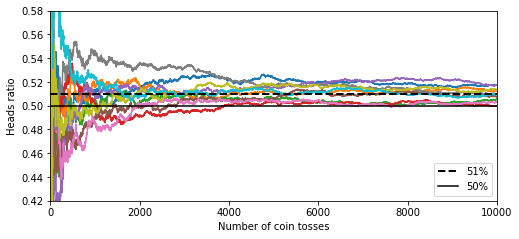

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
#save_fig("law_of_large_numbers_plot")
plt.show()

图7-3：大数定理

同样，假设创建了一个包含1000个分类器的集成，每个分类器都只有51%的几率是正确的（几乎没比随机猜测强多少）。如果你以大多数投票的类别作为预测结果，你可以期待的准确率高达75%。但是，这基于的前提是：**所有的分类器都是完全独立的，彼此的错误毫不相关。** 显然这是不可能的，因为它们都是在相同的数据上训练的。它们很可能会犯相同的错误，所以也会有很多次大多数投给了错误的类别，导致集成的准确率有所降低。

> 当预测器尽可能互相独立时，集成方法的效果最优。获得多种分类器的方法之一就是使用不同的算法进行训练。这会增加它们犯不同类型错误的机会，从而提升集成的准确率。

下面的代码用Scikit-Learn创建并训练一个投票分类器，由三种不同的分类器组成（训练集是卫星数据集，见第5章）：

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=55)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=55)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=55)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=55)
svm_clf = SVC(gamma="auto", random_state=55, probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=55,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=55)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=55))])

看看每个分类器在测试集上的准确率：

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression(random_state=55, solver='liblinear')

LogisticRegression 0.816


RandomForestClassifier(n_estimators=10, random_state=55)

RandomForestClassifier 0.832


SVC(gamma='auto', probability=True, random_state=55)

SVC 0.864


VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=55,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=55)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=55))])

VotingClassifier 0.864


投票分类器略胜于所有单个分类器。

如果所有分类器都能够估算出类别的概率（即有`predict_proba()`方法），那么可以将概率在所有单个分类器上平均，然后让Scikit-Learn给出平均概率最高的类别作为预测。这被称为`软投票法`。通常来说，它比硬投票法的表现更优，因为它给予那些高度自信的投票更高的权重。而需要做的就是用`voting="soft"`代替`voting="hard"`，并确保所有分类器都可以估算出概率。

> 默认情况下，`SVC`类是不行的，所以需要将其超参数`probability`设置为True（这会导致SVC使用交叉验证来估算类别概率，减慢训练速度，并会添加`predict_proba()`方法）。如果修改上面代码为使用软投票，你会发现投票分类器的准确率达到91%以上！(random_state=55时，集成算法的准确率反而下降了……)

In [8]:
log_clf = LogisticRegression(solver="liblinear", random_state=55)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=55)
svm_clf = SVC(gamma="auto", probability=True, random_state=55)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=55,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=55)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=55))],
                 voting='soft')

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression(random_state=55, solver='liblinear')

LogisticRegression 0.816


RandomForestClassifier(n_estimators=10, random_state=55)

RandomForestClassifier 0.832


SVC(gamma='auto', probability=True, random_state=55)

SVC 0.864


VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=55,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=55)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=55))],
                 voting='soft')

VotingClassifier 0.848


## bagging和pasting

前面提到，获得不同种类分类器的方法之一是使用不同的训练算法。还有另一种方法是每个预测器使用的算法相同，但是在不同的训练集随机子集上进行训练。采样时如果将样本放回，这种方法叫作`bagging` [1] （bootstrap aggregating [2] 的缩写，也叫`自举汇聚法`）；采样时样本不放回，这种方法则叫用`pasting`。 [3]

换句话说，bagging和pasting都允许训练实例在多个预测器中被多次采样，但是只有bagging允许训练实例被同一个预测器多次采样。采样过程和训练过程如图7-4所示。

![pasting/bagging训练集采样和训练](images/VNote/20201030184546660_22114.png)

图7-4：pasting/bagging训练集采样和训练

一旦预测器训练完成，集成就可以通过简单地聚合所有预测器的预测，来对新实例做出预测。`聚合函数`通常是**统计法（即最多数的预测好比硬投票分类器一样）用于分类**，或是**平均法用于回归**。每个预测器单独的偏差都高于在原始训练集上训练的偏差，但是通过聚合，同时降低了偏差和方差。 [4] 总体来说，最终结果是，与直接在原始训练集上训练的单个预测器相比，集成的偏差相近，但是方差更低。

如图7-4所示，可以通过不同的CPU内核甚至是不同的服务器，并行地训练预测器。类似地，预测也可以并行。这正是bagging和pasting方法如此流行的原因之一，它们非常易于拓展。

### Scikit-Learn的bagging和pasting

Scikit-Learn提供了一个简单的API，可用`BaggingClassifier`类进行`bagging`和`pasting`（或`BaggingRegressor`用于回归）。以下代码训练了一个包含500个决策树分类器的集成， [5] 每次随机从训练集中采样100个训练实例进行训练，然后放回（这是一个bagging的示例，如果想使用pasting，只需要设置`bootstrap=False`即可）。参数`n_jobs`用来指示Scikit-Learn用多少CPU内核进行训练和预测（-1表示让Scikit-Learn使用所有可用内核）：

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=55), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=55)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=55),
                  max_samples=100, n_estimators=500, n_jobs=-1,
                  random_state=55)

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.856


In [12]:
tree_clf = DecisionTreeClassifier(random_state=55)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

DecisionTreeClassifier(random_state=55)

0.816


> 如果基础分类器能够估算类别概率（也就是具备`predict_proba()`方法），比如决策树分类器，那么`BaggingClassifier`自动执行的就是软投票法而不是硬投票法。

图7-5比较了两种决策边界，一个是单个的决策树，一个是由500个决策树组成的bagging集成（来自前面的代码），均在卫星数据集上训练完成。可以看出，集成预测的泛化效果很可能会比单独的决策树要好一些：二者偏差相近，但是集成的方差更小（两边训练集上的错误数量差不多，但是集成的决策边界更规则）。

In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

<Figure size 792x288 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Decision Tree')

<AxesSubplot:>

Text(0.5, 1.0, 'Decision Trees with Bagging')

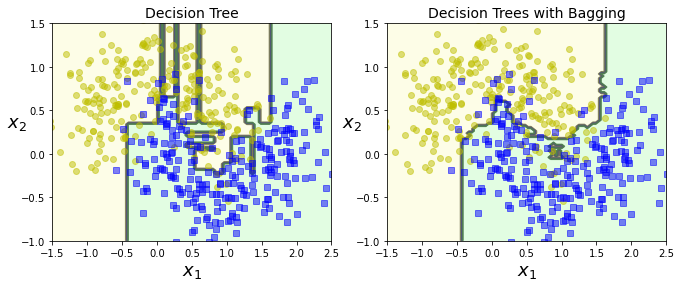

In [14]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
#save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

图7-5：单个的决策树与500个决策树的bagging集成对比

由于自助法给每个预测器的训练子集引入了更高的多样性，所以最后bagging比pasting的偏差略高，但这也意味着预测器之间的关联度更低，所以集成的方差降低。总之，**bagging生成的模型通常更好**，这也就是为什么它更受欢迎。但是，如果有充足的时间和CPU资源，可以使用交叉验证来对bagging和pasting的结果进行评估，再做出最合适的选择。

### 包外评估

对于任意给定的预测器，使用bagging，有些实例可能会被采样多次，而有些实例则可能根本不被采样。`BaggingClassifier`默认采样m个训练实例，然后放回样本（`bootstrap=True`），m是训练集的大小。这意味着对于每个预测器来说，平均只对63%的训练实例进行采样。 [6] 剩余37%未被采样的训练实例称为`包外`（oob）实例。注意，对所有预测器来说，这是不一样的37%。

既然预测器在训练的时候从未见过这些包外实例，正好可以用这些实例进行评估，从而不需要单独的验证集或是交叉验证。将每个预测器在其包外实例上的评估结果进行平均，就可以得到对集成的评估。

在Scikit-Learn中，创建`BaggingClassifier`时，设置`oob_score=True`，就可以请求在训练结束后自动进行包外评估。下面的代码演示了这一点。通过变量oob_score_可以得到最终的评估分数：

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=55), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=55)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=55),
                  n_estimators=500, n_jobs=-1, oob_score=True, random_state=55)

0.8826666666666667

根据包外评估结果，这个`BaggingClassifier`分类器很可能在测试集上达到约88.3%的准确率。我们来验证一下：

In [16]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.832

测试集上的准确率为83.2%！

每个训练实例的包外决策函数也可以通过变量`oob_decision_function_`获得。本例中（基础预测器具备`predict_proba()`方法），决策函数返回的是每个实例的类别概率。例如，包外评估估计，第二个训练实例有7.4%的概率属于正类（以及92.6%的概率属于负类）。

In [17]:
bag_clf.oob_decision_function_[:10]

array([[0.92432432, 0.07567568],
       [0.07446809, 0.92553191],
       [0.        , 1.        ],
       [0.02659574, 0.97340426],
       [0.        , 1.        ],
       [0.98930481, 0.01069519],
       [0.97206704, 0.02793296],
       [0.01015228, 0.98984772],
       [0.99428571, 0.00571429],
       [1.        , 0.        ]])

[1] “Bagging Predictors”，L.Breiman（1996）。

[2] 统计学中，放回重新采样称为自助法（bootstrapping）。

[3] “Pasting small votes for classification in large databases and on-line”，L.Breiman（1999）。

[4] 关于偏差和方差详见第4章介绍。

[5] max_samples可以在0.0到1.0之间灵活地设置，而每次采样的最大实例数量等于训练集的大小乘以max_samples。

[6] 随着m增长，这个比率接近1-exp（-1）≈63.212%。

## Random Patches和随机子空间

`BaggingClassifier`也支持对特征进行抽样，这通过两个超参数控制：`max_features`和`bootstrap_features`。它们的工作方式跟`max_samples`和`bootstrap`相同，只是抽样对象不再是实例，而是特征。因此，每个预测器将用输入特征的随机子集进行训练。

这对于处理高维输入（例如图像）特别有用。对训练实例和特征都进行抽样，被称为`Random Patches`方法。 [1] 而保留所有训练实例（即`bootstrap=False`并且`max_samples=1.0`）但是对特征进行抽样（即`bootstrap_features=True`并且/或`max_features<1.0`），这被称为`随机子空间法`。 [2]

对特征抽样给预测器带来更大的多样性，所以以略高一点的偏差换取了更低的方差。

[1] “Ensembles on Random Patches”，G.Louppe和P.Geurts（2012）。

[2] “The random subspace method for constructing decision forests”，Tin Kam Ho（1998）。

## 随机森林

前面已经提到，随机森林（ http://goo.gl/zVOGQ1 ） [1] 是决策树的集成，通常用bagging（有时也可能是pasting）方法训练，训练集大小通过`max_samples`来设置。除了先构建一个`BaggingClassifier`然后将结果传输到`DecisionTreeClassifier`，还有一种方法就是使用`RandomForestClassifier`类，这种方法更方便，对决策树更优化 [2] （同样，对于回归任务也有一个`RandomForestRegressor`类）。以下代码使用所有可用的CPU内核，训练了一个拥有500棵树的随机森林分类器（每棵树限制为最多16个叶节点）：

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=55),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=55)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_leaf_nodes=16,
                                                        random_state=55,
                                                        splitter='random'),
                  n_estimators=500, n_jobs=-1, random_state=55)

In [19]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=55)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=55)

In [20]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.984

除了少数例外，`RandomForestClassifier`具有`DecisionTreeClassifier`的所有超参数，以及`BaggingClassifier`的所有超参数，前者用来控制树的生长，后者用来控制集成本身。 [3]

随机森林在树的生长上引入了更多的随机性：分裂节点时不再是搜索最好的特征（参见第6章），而是在一个随机生成的特征子集里搜索最好的特征。这导致决策树具有更大的多样性，（再一次）用更高的偏差换取更低的方差，总之，还是产生了一个整体性能更优的模型。下面的`BaggingClassifier`大致与前面的`RandomForestClassifier`相同：

In [21]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

### 极端随机树

如前所述，随机森林里单棵树的生长过程中，每个节点在分裂时仅考虑到了一个随机子集所包含的特征。如果对每个特征使用随机阈值，而不是搜索得出的最佳阈值（如常规决策树），则可能让决策树生长得更加随机。

这种极端随机的决策树组成的森林，被称为`极端随机树`（ http://goo.gl/RHGEA4 ）集成 [4] （或简称`Extra-Trees`）。同样，它也是以更高的偏差换取了更低的方差。极端随机树训练起来比常规随机森林要快很多，因为在每个节点上找到每个特征的最佳阈值是决策树生长中最耗时的任务之一。

使用Scikit-Learn的`ExtraTreesClassifier`可以创建一个极端随机树分类器。它的API与`RandomForestClassifier`相同。同理，`ExtraTreesRegressor`与`RandomForestRegressor`的API也相同。

> 通常来说，很难预先知道一个`RandomForestClassifier`是否会比一个`ExtraTreesClassifier`更好或是更差。唯一的方法是两种都尝试一遍，然后使用交叉验证（还需要使用网格搜索调整超参数）进行比较。

### 特征重要性

最后，如果查看单个决策树会发现，重要的特征更可能出现在靠近根节点的位置，而不重要的特征通常出现在靠近叶节点的位置（甚至根本不出现）。因此，通过计算一个特征在森林中所有树上的平均深度，可以估算出一个特征的重要程度。Scikit-Learn在训练结束后自动计算每个特征的重要性。通过变量`feature_importances_`就可以访问到这个计算结果。例如，以下代码在鸢尾花数据集（见第4章）上训练了一个`RandomForestClassifier`，并输出了每个特征的重要性。看起来最重要的特征是花瓣长度（45%）和宽度（42%），而花萼的长度和宽度则相对不那么重要（分别是9%和3%）：

In [22]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=55)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=55)

sepal length (cm) 0.09750382493564654
sepal width (cm) 0.026472069112277122
petal length (cm) 0.45304833733119143
petal width (cm) 0.4229757686208848


同样，如果你在MNIST数据集（见第3章）上训练一个随机森林分类器，然后绘制其每个像素的重要性，你将得到如图7-6所示的图像。

In [23]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [24]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=55)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(n_estimators=10, random_state=55)

In [25]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

[Text(1, 0.0, 'Not important'),
 Text(1, 0.020931905609788724, 'Very important')]

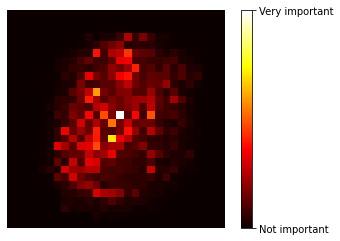

In [26]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

#save_fig("mnist_feature_importance_plot")
plt.show()

图7-6：MNIST像素位的重要性（根据随机森林分类器）

所以，如果想快速了解什么是真正重要的特征，随机森林是一个非常便利的方法，特别是当需要执行特征选择的时候。

[1] “Random Decision Forests”，T.Ho（1995）。

[2] 如果你想要对决策树之外的东西进行装袋（bag），BaggingClassifier还是有用的。

[3] 有几个值得注意的例外：没有splitter（强制为random），没有presort（强制为False），没有max_samples（强制为1.0），没有base_estimator（强制为DecisionTreeClassifier与给定超参数）。

[4] “Extremely randomized trees”，P.Geurts、D.Ernst和L.Wehenkel（2005）。

## 提升法

`提升法`（Boosting，最初被称为假设提升）是指可以将几个弱学习器结合成一个强学习器的任意集成方法。大多数提升法的总体思路是循环训练预测器，每一次都对其前序做出一些改正。可用的提升法有很多，但目前最流行的方法是AdaBoost（ http://goo.gl/OIduRW ） [1] （自适应提升法，Adaptive Boosting的缩写）和梯度提升。

### AdaBoost

新预测器对其前序进行纠正的办法之一，就是更多地关注前序拟合不足的训练实例。从而使新的预测器不断地越来越专注于难缠的问题，这就是AdaBoost使用的技术。

例如，要构建一个AdaBoost分类器，首先需要训练一个基础分类器（比如决策树），用它对训练集进行预测。然后对错误分类的训练实例增加其相对权重，接着，使用这个最新的权重对第二个分类器进行训练，然后再次对训练集进行预测，继续更新权重，并不断循环向前（见图7-7）。

![AdaBoost循环训练，实例权重不断更新](images/VNote/20201109112344496_4232.png)


图7-8显示了在卫星数据集上5个连续的预测器的决策边界（在本例中，每个预测器都是使用RBF核函数的高度正则化的SVM分类器 [2] ）。第一个分类器产生了许多错误实例，所以这些实例的权重得到提升。因此第二个分类器在这些实例上的表现有所提升，然后第三个、第四个……右图绘制的是相同预测器序列，唯一的差别在于学习率减半（即每次迭代仅提升一半错误分类的实例的权重）。可以看出，AdaBoost这种依序循环的学习技术跟梯度下降有一些异曲同工之处，差别只在于——不再是调整单个预测器的参数使成本函数最小化，而是不断在集成中加入预测器，使模型越来越好。

一旦全部预测器训练完成，集成整体做出预测时就跟bagging或pasting方法一样了，除非预测器有不同的权重，因为它们总的准确率是基于加权后的训练集。

 这种依序学习技术有一个重要的缺陷就是无法并行（哪怕只是一部分），因为每个预测器只能在前一个预测器训练完成并评估之后才能开始训练。因此，在拓展方面，它的表现不如bagging和pasting方法。

In [27]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=55)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=55)

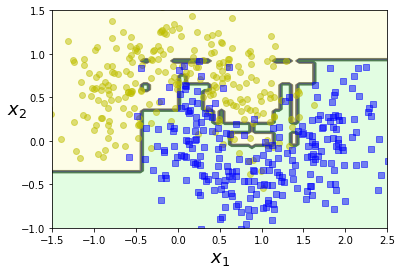

In [28]:
plot_decision_boundary(ada_clf, X, y)

<Figure size 792x288 with 0 Axes>

<AxesSubplot:>

SVC(C=0.05, gamma='auto', random_state=55)

Text(0.5, 1.0, 'learning_rate = 1')

SVC(C=0.05, gamma='auto', random_state=55)

Text(0.5, 1.0, 'learning_rate = 1')

SVC(C=0.05, gamma='auto', random_state=55)

Text(0.5, 1.0, 'learning_rate = 1')

SVC(C=0.05, gamma='auto', random_state=55)

Text(0.5, 1.0, 'learning_rate = 1')

SVC(C=0.05, gamma='auto', random_state=55)

Text(0.5, 1.0, 'learning_rate = 1')

Text(-0.7, -0.65, '1')

Text(-0.6, -0.1, '2')

Text(-0.5, 0.1, '3')

Text(-0.4, 0.55, '4')

Text(-0.3, 0.9, '5')

<AxesSubplot:>

SVC(C=0.05, gamma='auto', random_state=55)

Text(0.5, 1.0, 'learning_rate = 0.5')

SVC(C=0.05, gamma='auto', random_state=55)

Text(0.5, 1.0, 'learning_rate = 0.5')

SVC(C=0.05, gamma='auto', random_state=55)

Text(0.5, 1.0, 'learning_rate = 0.5')

SVC(C=0.05, gamma='auto', random_state=55)

Text(0.5, 1.0, 'learning_rate = 0.5')

SVC(C=0.05, gamma='auto', random_state=55)

Text(0.5, 1.0, 'learning_rate = 0.5')

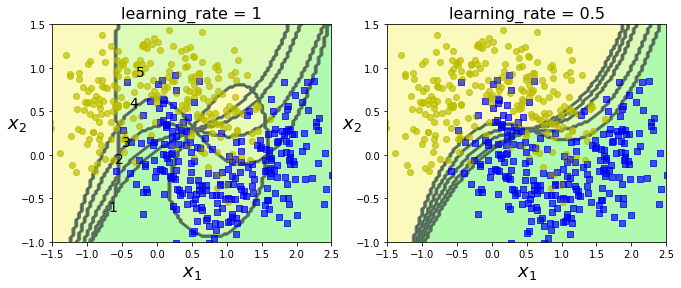

In [29]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=55)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

#save_fig("boosting_plot")
plt.show()

仔细看看AdaBoost算法。每个实例的权重$w^{(i)}$ 最初设置为$1/m$。第一个预测器训练后，计算其加权误差率$r_1$ ，见公式7-1。

$$
r_j = \frac{\displaystyle \sum_{\begin{array} {c}
    i=1 \\ \hat y_j^{(i)} \neq y_j^{(i)}
\end{array}}^m w^{(i)}} 
{\displaystyle \sum_{i=1}^m w^{(i)}} （其中，\hat y_j^{(i)}是第j个预测器对第i个实例做出的预测） \tag{7-1} \label{7-1}
$$

公式7-1：第j个预测器的加权误差率



预测器的权重$\alpha_j$通过公式7-2来计算，其中$\eta$是学习率超参数（默认为1）。 [3] 预测器的准确率越高，其权重就越高。如果它只是随机猜测，则其权重接近于零。但是，如果大部分情况下它都是错的（也就是准确率比随机猜测还低），那么它的权重为负。

公式7-2：预测器权重

$$
\alpha_j = \eta \log \frac{1-r_j}{r_j} \tag{7-2} \label{7-2}
$$

接下来，使用公式7-3，对实例的权重进行更新，也就是提升被错误分类的实例的权重。

$$
w^{(i)} \leftarrow
\left \{ 
\begin{array} {ll}
w^{(i)} &(\hat y_j^{(i)} = y^{(i)}) \\
w^{(i)} \exp(\alpha_j) &(\hat y_j^{(i)} \neq y^{(i)}) 
\end{array}
\right . \tag{7-3} \label{7-3}
$$

公式7-3：权重更新规则

然后将所有实例的权重归一化（即除以$\displaystyle \sum_{i=1}^m w^{(i)}$）。

最后，使用更新后的权重训练一个新的预测器，然后重复整个过程（计算新预测器的权重，更新实例权重，然后对另一个预测器进行训练，等等）。当到达所需数量的预测器，或得到完美的预测器时，算法停止。

预测的时候，AdaBoost就是简单地计算所有预测器的预测结果，并使用预测器权重$α_j$ 对它们进行加权。最后，得到大多数加权投票的类别就是预测器给出的预测类别（见公式7-4）。

$$
\hat y(x) = \argmax_k \sum_{\begin{array} {c}
    j=1 \\ \hat y_j(x)=k
\end{array}}^N \alpha_j (其中N是预测器的数量) \tag{7-4} \label{7-4}
$$

公式7-4：AdaBoost预测



Scikit-Learn使用的其实是AdaBoost的一个多分类版本，叫作`SAMME`（ http://goo.gl/Eji2vR ） [4] （基于多类指数损失函数的逐步添加模型）。当只有两个类别时，SAMME即等同于AdaBoost。此外，如果预测器可以估算类别概率（即具有`predict_proba()`方法），Scikit-Learn会使用一种SAMME的变体，称为`SAMME.R`（R代表“Real”），它依赖的是类别概率而不是类别预测，**通常表现更好**。

下面的代码使用Scikit-Learn的`AdaBoostClassifier`（还有一个`AdaBoostRegressor`类）训练了一个AdaBoost分类器，它基于200个单层决策树`n_estimators=200`（decision stump）。顾名思义，单层决策树就是`max_depth=1`的决策树，换言之，就是一个决策节点加两个叶节点。这是AdaBoostClassifier默认使用的基础估算器。

In [30]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

> 如果你的AdaBoost集成过度拟合训练集，你可以试试减少估算器数量，或是提高基础估算器的正则化程度。

### 梯度提升

另一个非常受欢迎的提升法是`梯度提升`（Gradient Boosting）。 [5] 跟AdaBoost一样，梯度提升（ http://goo.gl/Ezw4jL ）也是逐步在集成中添加预测器，每一个都对其前序做出改正。不同之处在于，它不是像AdaBoost那样在每个迭代中调整实例权重，而是**让新的预测器针对前一个预测器的残差进行拟合**。

看一个简单的回归示例，使用决策树作为基础预测器（梯度提升当然也适用于回归任务），这被称为`梯度树提升`或者是`梯度提升回归树`（GBRT）。首先，在训练集（比如带噪声的二次训练集）上拟合一个DecisionTreeRegressor：

In [31]:
np.random.seed(55)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=55)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=55)

现在，针对第一个预测器的残差，训练第二个`DecisionTreeRegressor`：

In [33]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=55)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=55)

然后，针对第二个预测器的残差，训练第三个回归器：

In [34]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=55)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=55)

现在，有了一个包含三棵树的集成。它将所有树的预测相加，从而对新实例进行预测：

In [35]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.67850081])

<Figure size 792x792 with 0 Axes>

<AxesSubplot:>

Text(0, 0.5, '$y$')

Text(0.5, 1.0, 'Residuals and tree predictions')

<AxesSubplot:>

Text(0, 0.5, '$y$')

Text(0.5, 1.0, 'Ensemble predictions')

<AxesSubplot:>

Text(0, 0.5, '$y - h_1(x_1)$')

<AxesSubplot:>

Text(0, 0.5, '$y$')

<AxesSubplot:>

Text(0, 0.5, '$y - h_1(x_1) - h_2(x_1)$')

Text(0.5, 0, '$x_1$')

<AxesSubplot:>

Text(0.5, 0, '$x_1$')

Text(0, 0.5, '$y$')

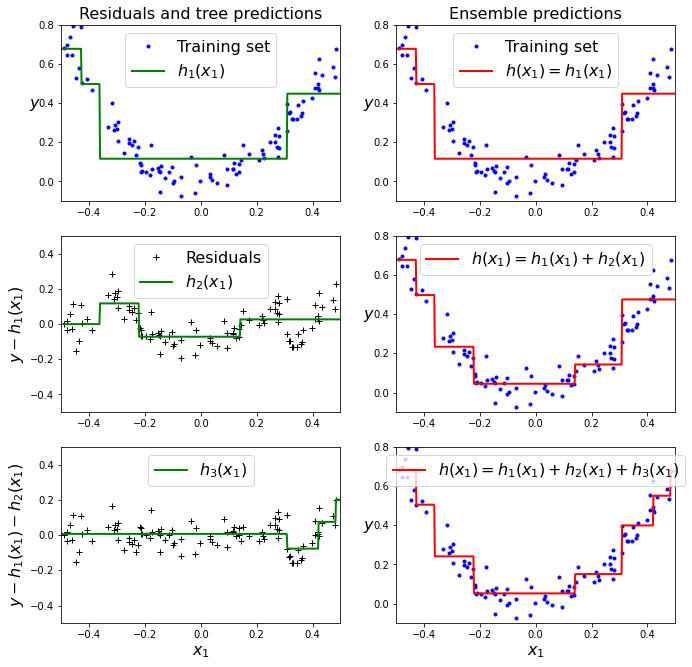

In [36]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

上图左侧表示这三棵树单独的预测，右侧表示集成的预测。第一行，集成只有一棵树，所以它的预测与第一棵树的预测完全相同。第二行是在第一棵树的残差上训练的一棵新树，从右侧可见，集成的预测等于前面两棵树的预测之和。类似地，第三行又有一棵在第二棵树的残差上训练的新树，集成的预测随着新树的添加逐渐变好。

训练`GBRT集成`有个简单的方法，就是使用Scikit-Learn的`GradientBoostingRegressor`类。与`RandomForestRegressor`类似，它具有控制决策树生长的超参数（例如`max_depth`、`min_samples_leaf`等），以及控制集成训练的超参数，例如树的数量（`n_estimators`）。以下代码可创建上面的集成：

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=55)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=55)

超参数`learning_rate`对每棵树的贡献进行缩放。如果将其设置为低值，比如0.1，则需要更多的树来拟合训练集，但是预测的泛化效果通常更好。这是一种被称为`收缩的正则化技术`。下图显示了用低学习率训练的两个GBRT集成：左侧拟合训练集的树数量不足，而右侧拟合训练集的树数量过多从而导致过度拟合。

要找到树的最佳数量，可以使用早期停止法（参见第4章）。简单的实现方法就是使用`staged_predict()`方法：它在训练的每个阶段（一棵树时，两棵树时，等等）都对集成的预测返回一个迭代器。以下代码训练了一个拥有120棵树的GBRT集成，然后测量每个训练阶段的验证误差，从而找到树的最优数量，最后使用最优树数重新训练了一个GBRT集成：

In [38]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=55)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=55)

<Figure size 792x288 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'learning_rate=1.0, n_estimators=3')

<AxesSubplot:>

Text(0.5, 1.0, 'learning_rate=0.1, n_estimators=200')

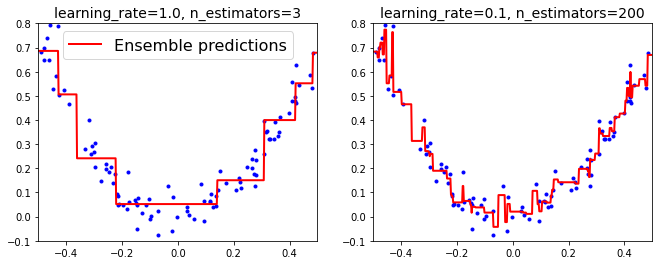

In [39]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

#save_fig("gbrt_learning_rate_plot")
plt.show()

图7-10：GBRT集成——预测器太少（左图）和预测器太多（右图）

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=55)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=55)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=55)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=55)

GradientBoostingRegressor(max_depth=2, n_estimators=30, random_state=55)

In [41]:
min_error = np.min(errors)

<Figure size 792x288 with 0 Axes>

<AxesSubplot:>

Text(30, 0.003816310596404916, 'Minimum')

(0.0, 120.0, 0.0, 0.01)

Text(0.5, 0, 'Number of trees')

Text(0.5, 1.0, 'Validation error')

<AxesSubplot:>

Text(0.5, 1.0, 'Best model (30 trees)')

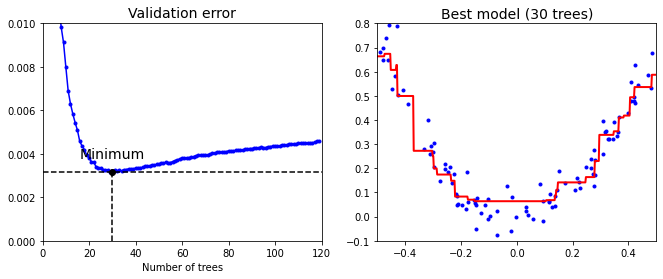

In [42]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

#save_fig("early_stopping_gbrt_plot")
plt.show()

图7-11：通过早期停止法调整树的数量


验证误差如上图左图所示，最好的模型预测如右图所示。

实际上，要实现早期停止法，不一定需要先训练大量的树，然后再回头找最优的数字，还可以真的提前停止训练。设置`warm_start=True`，当`fit()`方法被调用时，Scikit-Learn会保留现有的树，从而允许增量训练。以下代码会在验证误差连续5次迭代未改善时，直接停止训练：

In [43]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=55)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        # 连续5步均增加，则停止
        if error_going_up == 5:
            break  # early stopping

GradientBoostingRegressor(max_depth=2, n_estimators=1, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=2, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=3, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=4, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=5, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=6, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=7, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=8, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=9, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=10, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=11, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=12, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=13, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=14, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=15, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=16, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=17, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=18, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=19, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=20, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=21, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=22, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=23, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=24, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=25, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=26, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=27, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=28, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=29, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=30, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=31, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=32, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=33, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=34, random_state=55,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=35, random_state=55,
                          warm_start=True)

In [44]:
print(gbrt.n_estimators)

35


In [45]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.0031802588303374304


`GradientBoostingRegressor`类还可以支持超参数`subsample`，指定用于训练每棵树的实例的比例。例如，如果`subsample=0.25`，则每棵树用25%的随机选择的实例进行训练。这也是用更高的偏差换取了更低的方差，同时在相当大的程度上加速了训练过程。这种技术被称为随机梯度提升。

> 梯度提升也可以使用其他成本函数，通过超参数`loss`来控制（有关更多详细信息，请参阅Scikit-Learn的文档）。

[1] “A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting”，Yoav Freund和Robert E.Schapire（1997）。

[2] 这里只是为了举例说明。对于AdaBoost来说，SVM通常不是很好的基础预测器，因为它们很慢，并且由于使用了AdaBoost，很容易不稳定。

[3] 初始的AdaBoost算法不使用学习率超参数。

[4] 更详细内容可参考：“Multi-Class AdaBoost”，J.Zhu等人（2006）。

[5] 首次提出来自于“Arcing the Edge”，L.Breiman（1997），http://statistics.berkeley.edu/sites/default/files/tech-reports/486.pdf。

## 堆叠法

本章讨论的最后一个集成方法叫作`堆叠法`（stacking），又称`层叠泛化法`（ http://goo.gl/9I2NBw ）。 [1] 它基于一个简单的想法：**与其使用一些简单的函数（比如硬投票）来聚合集成中所有预测器的预测，为什么不训练一个模型来执行这个聚合呢？** 图7-12显示了在新实例上执行回归任务的这样一个集成。底部的三个预测器分别预测了不同的值（3.1、2.7和2.9），然后最终的预测器（称为混合器或元学习器）将这些预测作为输入，进行最终预测（3.0）。

训练混合器的常用方法是使用留存集。 [2] 我们看看它是如何工作的。首先，将训练集分为两个子集，第一个子集用来训练第一层的预测器（见图7-13）。

![图7-12：通过混合预测器聚合预测](images/VNote/20201124151327949_3189.png)


![图7-13：训练第一层](images/VNote/20201124151421695_7459.png)

然后，用第一层的预测器在第二个（留存）子集上进行预测（见图7-14）。因为预测器在训练时从未见过这些实例，所以可以确保预测是“干净的”。那么现在对于留存集中的每个实例都有了三个预测值。我们可以使用这些预测值作为输入特征，创建一个新的训练集（新的训练集有三个维度），并保留目标值。在这个新的训练集上训练混合器，让它学习根据第一层的预测来预测目标值。

![图7-14：训练混合器](images/VNote/20201124151537084_3977.png)

事实上，通过这种方法可以训练多种不同的混合器（例如，一个使用线性回归，另一个使用随机森林回归，等等）：于是可以得到一个混合器层。诀窍在于将训练集分为三个子集：第一个用来训练第一层，第二个用来创造训练第二层的新训练集（使用第一层的预测），而第三个用来创造训练第三层的新训练集（使用第二层的预测）。一旦训练完成，可以按照顺序遍历每层来对新实例进行预测，如图7-15所示。


![图7-15：一个多层堆叠集成的预测](images/VNote/20201124152201265_14199.png)

不幸的是，Scikit-Learn不直接支持堆叠，但是自己堆出stacking的实现品并不太难（参见接下来的练习）。或者，也可以使用开源的实现方案，例如brew（可从 https://github.com/viisar/brew 获得）。

[1] “Stacked Generalization”，D.Wolpert（1992）。

[2] 或者使用折外（out-of-fold）预测也可以。在某些情况下，这才被称为堆叠（stacking），而使用留存集被称为混合（blending）。但是对多数人而言，这二者是同义词。

## 练习

1.如果你已经在完全相同的训练集上训练了五个不同的模型，并且它们都达到了95%的准确率，是否还有机会通过结合这些模型来获得更好的结果？如果可以，该怎么做？如果不行，为什么？

有机会，通过集成算法进行投票。

标准答案：如果你已经训练了五个不同的模型，并且都达到了95％的精度，你可以尝试将它们组合成一个投票集成，这通常会带来更好的结果。如果模型之间非常不同（例如，一个SVM分类器，一个决策树分类器，以及一个Logistic回归分类器等），则效果更优。如果它们是在不同的训练实例（这是bagging和pasting集成的关键点）上完成训练，那就更好了，但如果不是，只要模型非常不同，这个集成仍然有效。

2.硬投票分类器和软投票分类器有什么区别？

硬投票，按不同的分类器的预测结果进行投票；软投票，按分类器的预测概率进行投票。

标准答案：2.硬投票分类器只是统计每个分类器的投票，然后挑选出得票最多的类别。软投票分类器计算出每个类别的平均估算概率，然后选出概率最高的类别。它比硬投票法的表现更优，因为它给予那些高度自信的投票更高的权重。但是它要求每个分类器都能够估算出类别概率才可以正常工作（例如，Scikit-Learn中的SVM分类器必须要设置probability=True）

3.是否可以通过在多个服务器上并行来加速bagging集成的训练？pasting集成呢？boosting集成呢？随机森林或stacking集成呢？

标准答案：对于bagging集成来说，将其分布在多个服务器上能够有效加速训练过程，因为集成中的每个预测器都是独立工作的。同理，对于pasting集成和随机森林来说也是如此。但是，boosting集成的每个预测器都是基于其前序的结果，因此训练过程必须是有序的，将其分布在多个服务器上毫无意义。对于stacking集成来说，某个指定层的预测器之间彼此独立，因而可以在多台服务器上并行训练，但是，某一层的预测器只能在其前一层的预测器全部训练完成之后，才能开始训练。

4.包外评估的好处是什么？

标准答案：包外评估可以对bagging集成中的每个预测器使用其未经训练的实例进行评估。不需要额外的验证集，就可以对集成实施相当公正的评估。所以，如果训练使用的实例越多，集成的性能可以略有提升。

5.是什么让极端随机树比一般随机森林更加随机？这部分增加的随机性有什么用？极端随机树比一般随机森林快还是慢？

标准答案：随机森林在生长过程中，每个节点的分裂仅考虑到了特征的一个随机子集。极限随机树也是如此，它甚至走得更远：常规决策树会搜索出特征的最佳阈值，极限随机树直接对每个特征使用随机阈值。这种极限随机性就像是一种正则化的形式：如果随机森林对训练数据出现过度拟合，那么极限随机树可能执行效果更好。更甚的是，极限随机树不需要计算最佳阈值，因此它训练起来比随机森林快得多。但是，在做预测的时候，相比随机森林它不快也不慢。

6.如果你的AdaBoost集成对训练数据拟合不足，你应该调整哪些超参数？怎么调整？

提高n_estimators

标准答案：如果AdaBoost集成对训练集拟合不足，可以尝试提升估算器的数量或是降低基础估算器的正则化超参数。也可以尝试略微提升学习率。

7.如果你的梯度提升集成对训练集过度拟合，你是应该提升还是降低学习率？

过度拟合，提升学习率。

标准答案：如果你的梯度提升集成对训练集过度拟合，应该试着降低学习率（？这个和教程里的演示不同啊），也可以通过早停法来寻找合适的预测器数量（可能是因为预测器太多）。

8.加载MNIST数据集（第3章中有介绍），将其分为一个训练集、一个验证集和一个测试集（例如使用40000个实例训练，10000个实例验证，最后10000个实例测试）。然后训练多个分类器，比如一个随机森林分类器、一个极端随机树分类器和一个SVM。接下来，尝试使用软投票法或者硬投票法将它们组合成一个集成，这个集成在验证集上的表现要胜过它们各自单独的表现。成功找到集成后，在测试集上测试。与单个的分类器相比，它的性能要好多少？

In [46]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [47]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=55)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=55)

In [48]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [49]:
random_forest_clf = RandomForestClassifier(n_estimators=10, random_state=55)
extra_trees_clf = ExtraTreesClassifier(n_estimators=10, random_state=55)
svm_clf = LinearSVC(random_state=55)
mlp_clf = MLPClassifier(random_state=55)

In [50]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(n_estimators=10, random_state=55)


RandomForestClassifier(n_estimators=10, random_state=55)

Training the ExtraTreesClassifier(n_estimators=10, random_state=55)


ExtraTreesClassifier(n_estimators=10, random_state=55)

Training the LinearSVC(random_state=55)


/home/zhuangbin/pyenv/jupyter/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(random_state=55)

Training the MLPClassifier(random_state=55)


MLPClassifier(random_state=55)

In [51]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9449, 0.947, 0.7382, 0.9676]

In [52]:
from sklearn.ensemble import VotingClassifier

In [53]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [54]:
voting_clf = VotingClassifier(named_estimators)

In [55]:
voting_clf.fit(X_train, y_train)

/home/zhuangbin/pyenv/jupyter/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=55)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(n_estimators=10,
                                                   random_state=55)),
                             ('svm_clf', LinearSVC(random_state=55)),
                             ('mlp_clf', MLPClassifier(random_state=55))])

In [56]:
voting_clf.score(X_val, y_val)

0.9658

In [57]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9449, 0.947, 0.7382, 0.9676]

In [58]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=55)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(n_estimators=10,
                                                   random_state=55)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=55))])

In [59]:
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(n_estimators=10, random_state=55)),
 ('extra_trees_clf', ExtraTreesClassifier(n_estimators=10, random_state=55)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=55))]

In [60]:
voting_clf.estimators_

[RandomForestClassifier(n_estimators=10, random_state=55),
 ExtraTreesClassifier(n_estimators=10, random_state=55),
 LinearSVC(random_state=55),
 MLPClassifier(random_state=55)]

In [61]:
del voting_clf.estimators_[2]

In [62]:
voting_clf.score(X_val, y_val)

0.9654

In [63]:
voting_clf.voting = "soft"

In [64]:
voting_clf.score(X_val, y_val)

0.9741

In [65]:
voting_clf.score(X_test, y_test)

0.9694

In [66]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9399, 0.9472, 0.9635]

9.运行上一个练习中的单个分类器，用验证集进行预测，然后用预测结果创建一个新的训练集：新训练集中的每个实例都是一个向量，这个向量包含所有分类器对于一张图像的一组预测，目标值是图像的类别。恭喜，你成功训练了一个混合器，结合第一层的分类器，它们一起构成了一个stacking集成。现在在测试集上评估这个集成。对于测试集中的每张图像，使用所有的分类器进行预测，然后将预测结果提供给混合器，得到集成的预测。与前面训练的投票分类器相比，这个集成的结果如何？

In [67]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [68]:
X_val_predictions

array([[3., 3., 9., 3.],
       [1., 1., 1., 1.],
       [3., 3., 9., 3.],
       ...,
       [6., 6., 6., 6.],
       [7., 7., 7., 7.],
       [0., 0., 0., 0.]], dtype=float32)

In [69]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=55)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=55)

In [70]:
rnd_forest_blender.oob_score_

0.966

In [71]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [72]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [73]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9618